<a href="https://colab.research.google.com/github/mohammadsanaee/ML_in_application/blob/main/6_rnn_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title <b><font color="red">▶</font><font color="black"> run this cell to prepare supplementary materials for the lesson</font></b>

!rm -rf harbour-space-text-mining-course
!git clone https://github.com/horoshenkih/harbour-space-text-mining-course.git
import sys
if 'harbour-space-text-mining-course' not in sys.path:
    sys.path.append('harbour-space-text-mining-course')

# from tmcourse.demo import (
# )
# from tmcourse.quiz import (
# )
from tmcourse.ipyquiz import Quiz, Function
from tmcourse.utils import enable_mathjax_in_cell

from IPython.display import HTML, display

# get_ipython().events.register('pre_run_cell', enable_mathjax_in_cell)
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 6.0)

import torch
torch.manual_seed(0)


Cloning into 'harbour-space-text-mining-course'...
remote: Enumerating objects: 738, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 738 (delta 79), reused 158 (delta 69), pack-reused 563
Receiving objects: 100% (738/738), 179.50 MiB | 14.63 MiB/s, done.
Resolving deltas: 100% (403/403), done.
Updating files: 100% (129/129), done.


<!--@slideshow slide-->
<h1><center>Recurrent Neural Networks - 2</center></h1>


<!--@slideshow slide-->
# Last time
1. Recurrent functions accept sequences as inputs.
$$
h_t = f(x_t, h_{t-1})
$$
1. Recurrent Neural Networks are recurrent _layers_: they consist of linear transformations followed by activation functions.
$$
h_t = \mathrm{SomeFunction}(W_{xh}x_t + W_{hh}h_{t-1})
$$
1. RNNs are trained with backpropagation on "unrolled" computational graph.
1. Example: classification of names with RNN.

<!--@slideshow slide-->
# Plan for today
1. Methods of gradient optimization.
1. When RNN fails: conflicting updates.
1. Long Short-Term Memory (LSTM)

<!--@slideshow slide-->
# Methods of gradient optimization
## Colab demo: gradient methods for neural networks
[link](https://colab.research.google.com/drive/1TEX4GuQLU1oEYes-zhAMvoahRZ1yJHMl?usp=sharing)

<!--@slideshow slide-->
## Colab demo: PyTorch optimizers

In [ ]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    # the same as LanguageModelRNN from the previous lecture, but without conditioning
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size

        # hidden -> hidden
        self.hh = nn.Linear(hidden_size, hidden_size)
        # input -> hidden
        self.xh = nn.Linear(input_size, hidden_size)
        # hidden -> output
        self.hy = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, h):
        # h_t = f(h_{t-1}, x_t)
        hidden = self.relu(self.hh(h) + self.xh(x))
        # o_t = g(h_t)
        output = self.softmax(self.hy(hidden))
        return output, hidden

    def h0(self):
        return torch.zeros(1, self.hidden_size)

`process_sequence_rnn()` builds many-to-many computational graph.

![link text](https://raw.githubusercontent.com/horoshenkih/harbour-space-text-mining-course/master/pic/rnn-lm.png)

In [ ]:
def process_sequence_rnn(
    rnn,
    input_line_tensor,
    target_line_tensor,
    learning_rate
):
    # instead of manual parameter update, we will use PyTorch optimizer
    # create the optimizer
    optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
    optimizer.zero_grad()

    loss_function = nn.NLLLoss()
    hidden = rnn.h0()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(input_line_tensor[i], hidden)
        # update the loss for each element x_t
        l = loss_function(output, target_line_tensor[i])
        loss += l

    loss.backward()

    # perform gradient step
    
    # last time, we implemented the gradient step like this:
    # >> with torch.no_grad():
    # >>     for parameter in rnn.parameters():
    # >>         parameter -= learning_rate * parameter.grad

    # now, we use optimizer
    optimizer.step()

    return loss.item() / input_line_tensor.size(0)

<!--@slideshow slide-->
# When RNN fails: conflicting updates

In [ ]:
#@slideshow slide
def toy_example(char_seq):
    """
    Synthetic dataset.
    Input: sequence of characters `char_seq`.
    Target: "turn on" 1 if "+" is found, wait for "-" to "turn off".
    """
    target = []
    turned_on = 0
    for c in char_seq:
        if c == "+":
            turned_on = 1
        elif c == "-":
            turned_on = 0
        target.append(turned_on)
    return target

inp = "aajh-dd+dklddf+dd-jjola"
print("input: ", inp)
print("target:", "".join(map(str, toy_example(inp))))

input:  aajh-dd+dklddf+dd-jjola
target: 00000001111111111000000


<!--@slideshow slide-->
## Colab demo: train RNN on the toy dataset

Generate synthetic sequences with `generate_data()`.

In [ ]:
import torch
import random

def get_vocabulary(n_additional_symbols):
    lower = "abcdefghijklmnopqrstuvwxyz"
    return list("+-" + lower[:n_additional_symbols])

def generate_data(n_samples, seed=0, n_additional_symbols=0):
    alphabet = get_vocabulary(n_additional_symbols)
    random.seed(seed)

    char_tensor = torch.zeros(n_samples, 1, len(alphabet))  # one-hotted, 1 batch
    target_tensor = torch.zeros(n_samples, 1)
    index_seq = random.choices(range(len(alphabet)), k=n_samples)
    char_seq = [alphabet[i] for i in index_seq]  # human-readable
    for k, idx in enumerate(index_seq):
        char_tensor[k][0][idx] = 1
    
    # target: turn on if "+", turn off if "-"
    target_seq = toy_example(char_seq)
    for i, target in enumerate(target_seq):
        target_tensor[i][0] = target

    return "".join(char_seq), "".join(map(str, target_seq)), char_tensor, target_tensor.type(torch.LongTensor)

print("0 additional symbols")
chars, target, chars_tensor, target_tensor = generate_data(100)
print(chars)
print(target)
print()

print("10 additional symbols")
chars, target, chars_tensor, target_tensor = generate_data(100, n_additional_symbols=10)
print(chars)
print(target)

0 additional symbols
--++-+-++---+--+----+---+++---+-+--+-+--++-++-+-+--+++--+--------+-+-+++--++-------+-+------+----+-+
0011010110001001000010001110001010010100110110101001110010000000010101110011000000010100000010000101

10 additional symbols
ihdbechbdfiebhfbijhibgigd-dfijdibhe+gchg+diabiaeajhd+bej-egehejffdfcebaaffd-hijiijecgbhiifjedfjjh+fd
0000000000000000000000000000000000011111111111111111111100000000000000000000000000000000000000000111


Training loop for many-to-many RNN.

In [ ]:
def train_many_to_many_rnn(
    n_additional_symbols=0,
    hidden_size=16,
    sequence_length=50,
    n_iters=1000,
    learning_rate=0.0005
):
    from tqdm.notebook import tqdm
    import numpy as np
    import matplotlib.pyplot as plt
    print_every = n_iters // 20

    rnn = RNN(n_additional_symbols + 2, hidden_size, 2)
    all_losses = []
    iterations = []
    losses = []

    for i in tqdm(range(1, n_iters + 1)):
        # random sample
        chars, target, input_tensor, target_tensor = generate_data(
            sequence_length,
            seed=i,
            n_additional_symbols=n_additional_symbols
        )
        loss = process_sequence_rnn(
            rnn,
            input_tensor,
            target_tensor,
            learning_rate
        )

        all_losses.append(loss)

        if i % print_every == 0:
            iterations.append(i)
            avg_loss = np.mean(all_losses[-print_every:])
            losses.append(avg_loss)
            print(f"iteration {i}: loss {avg_loss}")

    plt.plot(iterations, losses)
    plt.show()

    return rnn

Auxiliary functions.

In [ ]:
def evaluate(rnn, input_tensor):
    # read the sequence and return the final output
    hidden = rnn.h0()

    outputs = torch.zeros(input_tensor.size()[0], 1, 2)
    for i in range(input_tensor.size()[0]):
        output, hidden = rnn(input_tensor[i], hidden)
        outputs[i][0] = output

    return outputs

def prediction_chars(prediction_tensor):
    chars = []
    for i in range(prediction_tensor.size()[0]):
        if prediction_tensor[i][0][0] > prediction_tensor[i][0][1]:
            chars.append('0')
        else:
            chars.append('1')
    return chars

def visualize_predictions(rnn, seed, n_additional_symbols, sequence_length=50):
    chars, target, input_tensor, target_tensor = generate_data(
        sequence_length,
        seed=seed,
        n_additional_symbols=n_additional_symbols
    )

    prediction = evaluate(rnn, input_tensor)

    print("input:     ", "".join(chars))
    print("target:    ", "".join(target))
    print("prediction:", "".join(prediction_chars(prediction)))

### Case 1: 2 symbols in the input sequence (no additional symbols)

This is an easy task for RNN, training converges quickly, the resulting loss is close to 0.

  0%|          | 0/1500 [00:00<?, ?it/s]

iteration 75: loss 0.544311473083496
iteration 150: loss 0.42214077301025393
iteration 225: loss 0.31967441050211587
iteration 300: loss 0.22095592498779293
iteration 375: loss 0.14910698827107743
iteration 450: loss 0.09697605520884196
iteration 525: loss 0.060243048159281415
iteration 600: loss 0.03533760083516439
iteration 675: loss 0.019528934288024904
iteration 750: loss 0.010323584135373435
iteration 825: loss 0.005165799605846405
iteration 900: loss 0.0024941306233406063
iteration 975: loss 0.0011250098546346028
iteration 1050: loss 0.0004877078967789808
iteration 1125: loss 0.00020081621396044892
iteration 1200: loss 7.876471616327763e-05
iteration 1275: loss 2.9897694739823537e-05
iteration 1350: loss 1.0367474316929779e-05
iteration 1425: loss 3.2356778916437177e-06
iteration 1500: loss 1.0028510174985666e-06


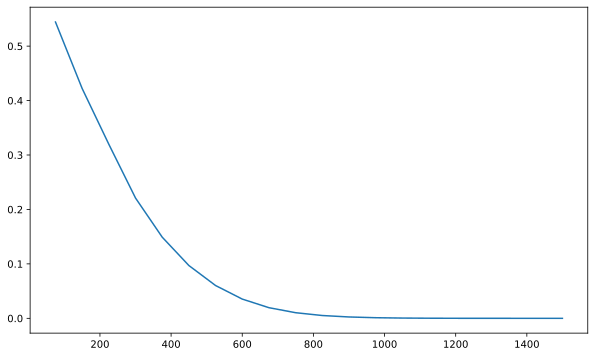

In [ ]:
rnn = train_many_to_many_rnn(n_additional_symbols=0, n_iters=1500)

In [ ]:
visualize_predictions(rnn, 99999, 0)

input:      ++--+++---+++----+-+--+-+-----+-+--+-++++-+----+++
target:     11001110001110000101001010000010100101111010000111
prediction: 11001110001110000101001010000010100101111010000111


### Case 2: 10 additional symbols
More iterations are needed to converge, the resulting loss is higher.

  0%|          | 0/4000 [00:00<?, ?it/s]

iteration 200: loss 0.6791394058227539
iteration 400: loss 0.6509730596542359
iteration 600: loss 0.597001141166687
iteration 800: loss 0.46430978860855104
iteration 1000: loss 0.36185636272430416
iteration 1200: loss 0.29194607143402096
iteration 1400: loss 0.28743749458789825
iteration 1600: loss 0.2028092038154602
iteration 1800: loss 0.202685067820549
iteration 2000: loss 0.1377129690170288
iteration 2200: loss 0.09727391933202745
iteration 2400: loss 0.0916478097230196
iteration 2600: loss 0.11027652328461411
iteration 2800: loss 0.06830874230563641
iteration 3000: loss 0.08100080782547593
iteration 3200: loss 0.11970627084597947
iteration 3400: loss 0.07670870947539807
iteration 3600: loss 0.12555780127756297
iteration 3800: loss 0.07170886358032003
iteration 4000: loss 0.08038174585886299


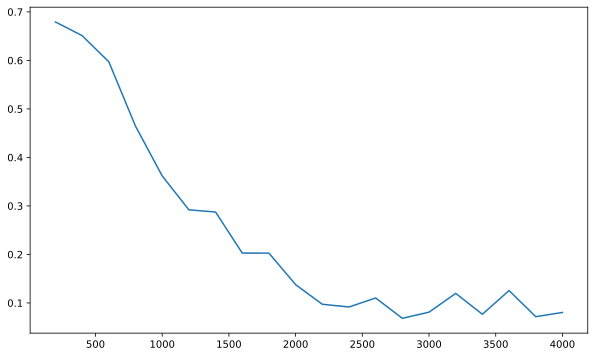

In [ ]:
rnn = train_many_to_many_rnn(n_additional_symbols=10, n_iters=4000)

In [ ]:
visualize_predictions(rnn, 99999, 10)

input:      -bjgcacjfh+bcehegajbhg-f-fiefjchcge-ic++dh+iehfb+c
target:     00000000001111111111110000000000000000111111111111
prediction: 00000000001111111111110000000000000000111111111111


### Case 3: 26 additional symbols
Note that there are 28 symbols but only 16 components in the hidden state.
This is typical for practical applications: the size of vocabulary is larger than the number of components of the hidden state.

The loss is high during training, more iterations don't help.

  0%|          | 0/15000 [00:00<?, ?it/s]

iteration 750: loss 0.6752082318623861
iteration 1500: loss 0.6003898242696126
iteration 2250: loss 0.5261197650766373
iteration 3000: loss 1.3373707332658769
iteration 3750: loss 0.2629711418664456
iteration 4500: loss 0.16076250575383505
iteration 5250: loss 0.1678879845571192
iteration 6000: loss 0.2180692776807553
iteration 6750: loss 0.21443809777196515
iteration 7500: loss 0.2402392353184087
iteration 8250: loss 0.29097282886009934
iteration 9000: loss 0.34977231500032024
iteration 9750: loss 0.2900275364629866
iteration 10500: loss 0.6044278183942958
iteration 11250: loss 1.6986582884546884
iteration 12000: loss 3.6633193520338687
iteration 12750: loss 6.110853751262439
iteration 13500: loss 11.269623892651133
iteration 14250: loss 12.428363972543531
iteration 15000: loss 7.6246637913960935


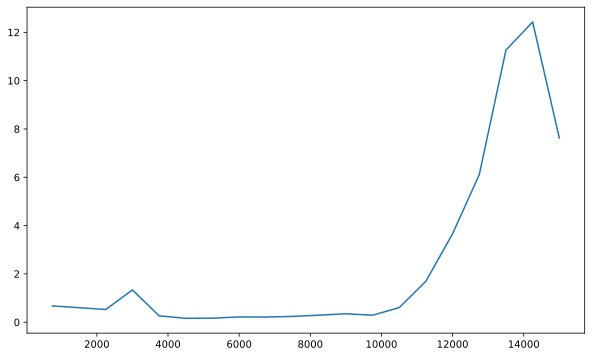

In [ ]:
rnn = train_many_to_many_rnn(n_additional_symbols=26, n_iters=15000)

In [ ]:
visualize_predictions(rnn, 99999, 26)

input:      bgyshdjxov-hioumrczhusaqboxmqzjuismbvj++jt-xnuqg+h
target:     00000000000000000000000000000000000000111100000011
prediction: 00000000000000000000000000000000000000111111111111


<!--@slideshow slide-->
## Problem: conflicting updates

RNN update rule:
$$
h_t = f(W_{xh} x_t + W_{hh} h_{t-1})
$$

**Problem**: $h_t$ is always updated, but _sometimes_ (for some inputs) we want to protect it from updates.


<!--@slideshow slide-->

**Notation**: one-hot encoding of inputs and outputs.

**Input**:
$x = (0, 1, \dots)^T$
corresponds to `"+"` character, and
$x = (1, 0, \dots)^T$
corresponds to `"-"` character.

Any other character is represented as
$x = (0, 0, \dots)^T$

**Output**:
$h = (0, 1)^T$
corresponds to label 1, and
$h = (1, 0)^T$
corresponds to label 0.

<!--@slideshow fragment-->
Only the first two components of $x_t$ are relevant, so we want
$$
W_{xh} = \begin{pmatrix}
1 & 0 & 0 & 0 & \dots\\
0 & 1 & 0 & 0 & \dots\\
\end{pmatrix}
$$

We need the update rule with "protection":
$$
h_t = \begin{cases}
W_{xh} x_t & \textrm{if }W_{xh} x_t \textrm{ is nonzero}\\
h_{t-1}, & \textrm{if }W_{xh} x_t \textrm{ is zero}
\end{cases}
$$

<!--@slideshow slide-->
# Long Short-Term Memory (LSTM)

[Sepp Hochreiter and Jürgen Schmidhuber, “Long Short-Term Memory,” Neural Computation 9, no. 8 (1997).](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.676.4320&rep=rep1&type=pdf)

<table>
  <tr>
    <td><img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/05/Example-of-LSTM-Architecture.png" height="400"/></td>
    <td><img src="https://static.tvtropes.org/pmwiki/pub/images/6db_3.jpg" height="400"/> </td> 
  </tr>
</table>


<!--@slideshow slide-->
**Idea**: treat the hidden state as "memory" and control its updates depending on the input.

> This is the same what we do in the toy example: update the state only for the particular inputs (`"+"` or `"-"`).

<!--@slideshow fragment-->
**What we have**: layers (matrices + nonlinearities).

**What we want**: memory, conditions (if-else).

<!--@slideshow slide-->
**Memory** will be represented as a vector.
- Each element stores a real number.
- An element can be erased.
- An element can be incremented/decremented.

<!--@slideshow fragment-->
**Conditions** correspond to the _sigmoid function_, which returns values between 0 ("False") and 1 ("True").

<!--@slideshow fragment-->
**Memory updates** (increments and decrements) correspond to _tanh_, which returns values between -1 ("decrement") and 1 ("increment").

<!--@slideshow slide-->
## 1. Cell state and output gate

In general, algorithms don't return the full memory state. So we need to
1. Separate the full memory state from the returning state
1. Decide which parts of the full memory state to return


<!--@slideshow fragment-->
The full memory state is called **cell state** $c_t$.

From the cell state $c_t$, we "return" only some elements.


<!--@slideshow slide-->
We need a function $o_t$ that tells which elements of $c_t$ should be returned:
- This function depends on inputs: $o_t(x_t, h_{t-1})$.
- For each element, it should "return" 0 or 1.
- We will _learn_ this function, so represent it as a layer:
$$
o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho})
$$

The function $o_t$ that decides which parts of memory to return is called **output gate**.


<!--@slideshow fragment-->
Also, we control the magnitute of the output using tanh:
$$
h_t = o_t \odot \mathrm{tanh}(c_t)
$$

<!--@slideshow slide-->
## 2. Update cell state

From the input $x_t, h_{t-1}$, we decide how to update the cell state $c_t$ (increment or decrement elements).
$$
g_t = \mathrm{tanh}(W_{ig}x_t + b_{ig} + W_{hg}h_{t-1} + b_{hg})
$$




<!--@slideshow fragment-->
But we cannot write
$$
c_t = g_t
$$
because we also need to _protect_ some parts of memory.

<!--@slideshow slide-->
## 3. Input gate and forget gate

To _protect_ some parts of memory $c_t$ from overwriting, we need a function $i_t$ that tells which elements should be overwritten.


<!--@slideshow fragment-->
Again, it should return "boolean" (between 0 and 1) values, and we learn it, so it is a layer:
$$
i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi}h_{t-1} + b_{hi})
$$

This function is called **input gate**.

<!--@slideshow slide-->
Similarly, we need to erase (forget) some parts of memory.




<!--@slideshow fragment-->
We need a function $f_t$  (**forget gate**) that "zeroes out" some elements of $c_t$ depending on input.
$$
f_t = \sigma(W_{if}x_t + b_{if} + W_{hf} h_{t-1} + b_{hf})
$$

<!--@slideshow slide-->
The final update of the cell state is
$$
c_t = f_t \odot c_{t-1} + i_t \odot g_t
$$

<!--@slideshow slide-->
Putting it all together, we obtain _LSTM equations_:

$$
i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi}h_{t-1} + b_{hi})
$$
$$
f_t = \sigma(W_{if}x_t + b_{if} + W_{hf} h_{t-1} + b_{hf})
$$
$$
g_t = \mathrm{tanh}(W_{ig}x_t + b_{ig} + W_{hg}h_{t-1} + b_{hg})
$$
$$
o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho})
$$
$$
c_t = f_t \odot c_{t-1} + i_t \odot g_t
$$
$$
h_t = o_t \odot \mathrm{tanh}(c_t)
$$

<!--@slideshow slide-->
## Colab demo: LSTM implementation in PyTorch

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size

        # input gate
        self.ii = nn.Linear(input_size, hidden_size)
        self.hi = nn.Linear(hidden_size, hidden_size)

        # forget gate
        self.if_ = nn.Linear(input_size, hidden_size)
        self.hf = nn.Linear(hidden_size, hidden_size)

        # cell
        self.ig = nn.Linear(input_size, hidden_size)
        self.hg = nn.Linear(hidden_size, hidden_size)

        # output gate
        self.io = nn.Linear(input_size, hidden_size)
        self.ho = nn.Linear(hidden_size, hidden_size)

        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

        # transformation of LSTM output to log-probabilities
        self.oo = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, state):
        h, c = state  # state is a pair of hidden state and cell state

        # input gate
        i = self.sigmoid(self.ii(x) + self.hi(h))
        # forget gate
        f = self.sigmoid(self.if_(x) + self.hf(h))
        # cell
        g = self.tanh(self.ig(x) + self.hg(h))
        # output gate
        o = self.sigmoid(self.io(x) + self.ho(h))

        # update cell state
        cell = f * c + i * g
        # update hidden state
        hidden = o * self.tanh(cell)

        # output
        output = self.softmax(self.oo(hidden))

        return output, (hidden, cell)

    def h0c0(self):
        return torch.zeros(1, self.hidden_size), torch.zeros(1, self.hidden_size)

In [ ]:
def process_sequence_lstm(
    lstm,
    input_line_tensor,
    target_line_tensor,
    learning_rate
):
    loss_function = nn.NLLLoss()
    state = lstm.h0c0()
    lstm.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, state = lstm(input_line_tensor[i], state)
        # update the loss for each element x_t
        l = loss_function(output, target_line_tensor[i])
        loss += l

    loss.backward()

    # instead of manual parameter update, we use PyTorch optimizer
    # create the optimizer
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
    # perform gradient step
    optimizer.step()

    return loss.item() / input_line_tensor.size(0)

In [ ]:
def train_many_to_many_lstm(
    n_additional_symbols=0,
    hidden_size=16,
    sequence_length=50,
    n_iters=1000,
    learning_rate=0.0005
):
    from tqdm.notebook import tqdm
    import numpy as np
    import matplotlib.pyplot as plt
    print_every = n_iters // 20

    lstm = LSTM(n_additional_symbols + 2, hidden_size, 2)
    all_losses = []
    iterations = []
    losses = []

    for i in tqdm(range(1, n_iters + 1)):
        # random sample
        chars, target, input_tensor, target_tensor = generate_data(
            sequence_length,
            seed=i,
            n_additional_symbols=n_additional_symbols
        )
        loss = process_sequence_lstm(
            lstm,
            input_tensor,
            target_tensor,
            learning_rate
        )

        all_losses.append(loss)

        if i % print_every == 0:
            iterations.append(i)
            avg_loss = np.mean(all_losses[-print_every:])
            losses.append(avg_loss)
            print(f"iteration {i}: loss {avg_loss}")

    plt.plot(iterations, losses)
    plt.show()

    return lstm

### Case 1: 2 symbols in the input sequence (no additional symbols)

Sanity check: LSTM converges quickly.

In [ ]:
train_many_to_many_lstm(n_additional_symbols=0, n_iters=10)

  0%|          | 0/10 [00:00<?, ?it/s]

NameError: ignored

### Case 2: 10 additional symbols

LSTM has lower loss compared to RNN.

  0%|          | 0/4200 [00:00<?, ?it/s]

iteration 210: loss 0.6839922561645507
iteration 420: loss 0.6452383827936081
iteration 630: loss 0.555979918888637
iteration 840: loss 0.44411776297433037
iteration 1050: loss 0.3826439650853475
iteration 1260: loss 0.3094546903882707
iteration 1470: loss 0.2785807252611433
iteration 1680: loss 0.22065555972144715
iteration 1890: loss 0.15937646693275087
iteration 2100: loss 0.09918712352571034
iteration 2310: loss 0.05663982012726011
iteration 2520: loss 0.025908915593510582
iteration 2730: loss 0.009466806627455212
iteration 2940: loss 0.003073982688820078
iteration 3150: loss 0.000782057714537673
iteration 3360: loss 0.00016357334851220784
iteration 3570: loss 3.820124652702362e-05
iteration 3780: loss 6.6883866551766646e-06
iteration 3990: loss 1.390329252368853e-06
iteration 4200: loss 3.8886122623404436e-07


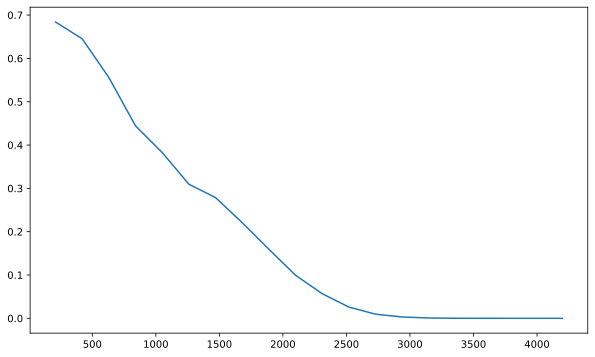

LSTM(
  (ii): Linear(in_features=12, out_features=16, bias=True)
  (hi): Linear(in_features=16, out_features=16, bias=True)
  (if_): Linear(in_features=12, out_features=16, bias=True)
  (hf): Linear(in_features=16, out_features=16, bias=True)
  (ig): Linear(in_features=12, out_features=16, bias=True)
  (hg): Linear(in_features=16, out_features=16, bias=True)
  (io): Linear(in_features=12, out_features=16, bias=True)
  (ho): Linear(in_features=16, out_features=16, bias=True)
  (tanh): Tanh()
  (sigmoid): Sigmoid()
  (oo): Linear(in_features=16, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [ ]:
train_many_to_many_lstm(n_additional_symbols=10, n_iters=4200)

### Case 3: 26 additional symbols

Training converges, more iterations are better.

  0%|          | 0/1500 [00:00<?, ?it/s]

iteration 75: loss 0.6817577997843426
iteration 150: loss 0.6785185938517253
iteration 225: loss 0.6677266789754234
iteration 300: loss 0.645179633585612
iteration 375: loss 0.6724300827026368
iteration 450: loss 0.6594034606933593
iteration 525: loss 0.6284150563557942
iteration 600: loss 0.640025205485026
iteration 675: loss 0.5995218409220378
iteration 750: loss 0.6498767313639323
iteration 825: loss 0.5704502187093097
iteration 900: loss 0.5493912465413412
iteration 975: loss 0.45413517265319825
iteration 1050: loss 0.49840948524475104
iteration 1125: loss 0.45343442560831704
iteration 1200: loss 0.4421963097890218
iteration 1275: loss 0.43323378016153974
iteration 1350: loss 0.3761661420822143
iteration 1425: loss 0.38481111272176105
iteration 1500: loss 0.37567300011316934


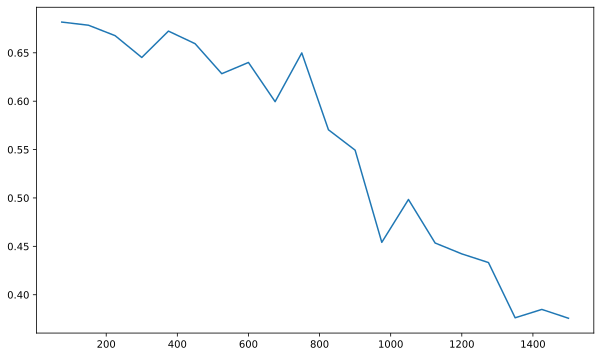

In [ ]:
lstm = train_many_to_many_lstm(n_additional_symbols=26, n_iters=1500)

<!--@slideshow slide-->
## Colab demo: `nn.LSTM`

In [107]:
import torch
import torch.nn as nn

class ClassificationLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

        # keep hidden sise for initialization of h_0, c_0
        self.hidden_size = hidden_size

    def forward(self, x):
        # Set initial states
        h0 = torch.zeros(1, 1, self.hidden_size)
        c0 = torch.zeros(1, 1, self.hidden_size)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (seq_len, batch, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.out(out[-1, :, :])

        return self.softmax(out)

In [108]:
def process_sequence_classification_lstm(lstm, target_tensor, input_tensor, learning_rate):
    loss_function = nn.NLLLoss()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

    output = lstm(input_tensor)
    loss = loss_function(output, target_tensor)

    # backprop + update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

Get the data

In [ ]:
#@title run this cell to copy-paste the code from the previous lecture: get the data, define ClassificationRNN

from collections import defaultdict
category_to_names = defaultdict(list)
with open("harbour-space-text-mining-course/datasets/pytorch_tutorial/names_by_language.txt") as f:
    for line in f:
        name, category = line.strip().split("\t")
        category_to_names[category].append(name)

# count total number of letters
all_letters = set()
all_categories = set()

for category, names in category_to_names.items():
    all_categories.add(category)
    for name in names:
        all_letters.update(list(name))
all_letters = list(sorted(all_letters))
all_categories = list(sorted(all_categories))

def name_to_tensor(name, all_letters):
    tensor = torch.zeros(len(name), 1, len(all_letters))
    for li, letter in enumerate(name):
        letter_idx = all_letters.index(letter)
        tensor[li][0][letter_idx] = 1  # one-hot encoding
    return tensor

category_to_training_samples = defaultdict(list)
for category, names in category_to_names.items():
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    for name in names:
        name_tensor = name_to_tensor(name, all_letters)
        sample = category_tensor, name_tensor
        category_to_training_samples[category].append(sample)

class ClassificationRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # instead of explicit matrix multiplications, we use Linear layers
        # W_hh: hidden -> hidden
        self.hh = nn.Linear(hidden_size, hidden_size)
        # W_xh: input -> hidden
        self.xh = nn.Linear(input_size, hidden_size)
        # W_hy: hidden -> output
        self.hy = nn.Linear(hidden_size, output_size)

        # nonlinearities we will use:
        # ReLU for h_t = f(h_{t-1}, x_t)
        self.relu = nn.ReLU()
        # LogSoftmax for y_t = g(h_t) (because we are doing classification)
        self.softmax = nn.LogSoftmax(dim=1)

        # keep hidden sise for initialization of h_0
        self.hidden_size = hidden_size

    def forward(self, x, h):
        # h_t = f(h_{t-1}, x_t)
        hidden = self.relu(self.hh(h) + self.xh(x))
        # y_t = g(h_t)
        output = self.softmax(self.hy(hidden))
        return output, hidden

    def h0(self):
        # compute the initial value (all zeros) for the hidden state
        return torch.zeros(1, self.hidden_size)
import torch

def process_sequence_classification(rnn, target_tensor, input_tensor, learning_rate):
    """
    The algorithm:
    - Read the input sequence left-to-right
    - At each step, compute new hidden state and new output
    - Get the last output (probability distribution over classes) and compute loss
    - Backpropagate gradients and update parameters

    input_tensor is a 3-dimensional tensor: sequence length x 1 x vocabulary size
     - the first dimension: each element in this dimension corresponds to x_t
     - the second dimension is a "batch dimension", in our case it always contains 1 element
     - the last dimension contains components of x_t
    """

    # prepare for backprop
    rnn.zero_grad()
    # initialize hidden state
    hidden = rnn.h0()

    # read all elements of the input sequence, update hidden state and output
    for i in range(input_tensor.size()[0]):
        output, hidden = rnn(input_tensor[i], hidden)

    # get the last output, compute the loss function and backpropagate
    loss_function = nn.NLLLoss()
    loss = loss_function(output, target_tensor)
    loss.backward()

    # update parameters
    with torch.no_grad():
        for parameter in rnn.parameters():
            parameter -= learning_rate * parameter.grad

    return loss.item()

Create and train `ClassificationLSTM`. Compare with `ClassificationRNN`.

  0%|          | 0/30000 [00:00<?, ?it/s]

iteration 1500: LSTM loss 2.894873099565506, RNN loss 2.881076582590739
iteration 3000: LSTM loss 2.7473600008090338, RNN loss 2.8791540959676105
iteration 4500: LSTM loss 2.6561076455911, RNN loss 2.8719852242469788
iteration 6000: LSTM loss 2.6675141136447587, RNN loss 2.85947118139267
iteration 7500: LSTM loss 2.580185228347778, RNN loss 2.8544569341341655
iteration 9000: LSTM loss 2.5998510634799796, RNN loss 2.843252766450246
iteration 10500: LSTM loss 2.5457689182162286, RNN loss 2.835365706125895
iteration 12000: LSTM loss 2.6813925033807755, RNN loss 2.827980145454407
iteration 13500: LSTM loss 2.571714149509867, RNN loss 2.809374224503835
iteration 15000: LSTM loss 2.4846291289660147, RNN loss 2.797473304748535
iteration 16500: LSTM loss 2.4468680186614704, RNN loss 2.7824748633702594
iteration 18000: LSTM loss 2.3647461305273074, RNN loss 2.7638352039655047
iteration 19500: LSTM loss 2.324906009063125, RNN loss 2.750302448431651
iteration 21000: LSTM loss 2.1754984594999502, 

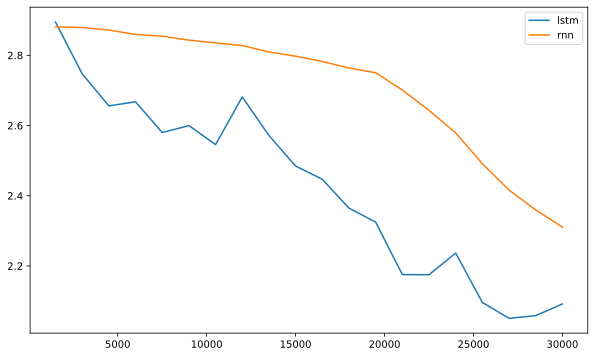

In [ ]:
n_hidden = 128
classification_lstm = ClassificationLSTM(len(all_letters), n_hidden, len(all_categories))
classification_rnn = ClassificationRNN(len(all_letters), n_hidden, len(all_categories))

import math
from tqdm.notebook import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
random.seed(0)

n_iters = 30000
print_every = 1500

all_losses = []
iterations = []
losses = []
all_rnn_losses = []
rnn_losses = []

for i in tqdm(range(1, n_iters + 1)):
    random_category = random.choice(all_categories)
    category_tensor, name_tensor = random.choice(category_to_training_samples[random_category])

    loss = process_sequence_classification_lstm(classification_lstm, category_tensor, name_tensor, 0.0005)
    all_losses.append(loss)

    rnn_loss = process_sequence_classification(classification_rnn, category_tensor, name_tensor, 0.001)
    all_rnn_losses.append(rnn_loss)
    if i % print_every == 0:
        iterations.append(i)
        avg_loss = np.mean(all_losses[-print_every:])
        losses.append(avg_loss)
        avg_rnn_loss = np.mean(all_rnn_losses[-print_every:])
        rnn_losses.append(avg_rnn_loss)
        print(f"iteration {i}: LSTM loss {avg_loss}, RNN loss {avg_rnn_loss}")

plt.plot(iterations, losses, label="lstm")
plt.plot(iterations, rnn_losses, label="rnn")
plt.legend()
plt.show()

<!--@slideshow slide-->
# Summary
1. Methods of gradient optimization: "vanilla", momentum, Nesterov momentum, Adagrad, RMSProp, Adam.
1. Conflicting updates in RNN
1. Long Short-Term Memory (LSTM)
  - Treat the hidden state as "memory" and control its updates depending on the input.
  - Cell state and cell update
  - Output gate
  - Input gate
  - Forget gate

<!--@slideshow slide-->
# Recommended resources
- [Deep Learning Book, ch. 10: Sequence Modeling: Recurrentand Recursive Nets](https://www.deeplearningbook.org/contents/rnn.html)
- [Understanding LSTMs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [Sepp Hochreiter and Jürgen Schmidhuber, “Long Short-Term Memory,” Neural Computation 9, no. 8 (1997).](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.676.4320&rep=rep1&type=pdf)

<!--@slideshow slide-->
# Home assignment 6
## Exercise 1 (2 points)
Refactor your solution from the Home Assignment 4: in the function `train_clf`, use Adam optimizer.

## Exercise 2 (4 points)
Refactor your solution from the Home Assignment 5 (Exercise 2): use `nn.LSTM` in `ClassificationRNN`.

In [ ]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch

def generate_data(xmin=-15, xmax=15, ymin=-15, ymax=15):
    points = []
    labels = []
    for x in range(xmin, xmax):
        for y in range(ymin, ymax):
            points.append((float(x), float(y)))
            labels.append(int(x * y < 0))
    return points, labels

def visualize_clf(clf, points):
    import matplotlib.pyplot as plt
    plt.axis('equal')
    X = []
    Y = []
    C = []
    for p in points:
        x, y = p  # x1, x2 instead of x, y
        r, g, b, a = 0, 0, 0, 0
        result = clf.forward(torch.tensor([x, y]))
        prob_1 = result[1].item()
        if prob_1 > 0.5:
            b = 1
        else:
            r = 1
        a = max(prob_1, 1 - prob_1)
        X.append(x)
        Y.append(y)
        C.append((r, g, b, a))
    plt.scatter(X, Y, c=C)
    plt.show()

In [ ]:
import torch
from torch import nn


class XORSolver(nn.Module):
    def __init__(self, N=10):
        super().__init__()
        torch.manual_seed(0)
        # YOUR CODE HERE
        # define the parameters W1, b1, W2, b2, W3, b3
        # initialize randomly
        self.N = N
        self.W1 = nn.Parameter(torch.randn(N, 2)-0.5)
        self.b1 = nn.Parameter(torch.randn(N)-0.5)
        self.W2 = nn.Parameter(torch.randn(N, N)-0.5)
        self.b2 = nn.Parameter(torch.randn(N)-0.5)
        self.W3 = nn.Parameter(torch.randn(2, N)-0.5)
        self.b3 = nn.Parameter(torch.randn(2)-0.5)
    def relu(self, x):
        return torch.max(x, torch.tensor([0.0], dtype=torch.float))
    def forward(self, xy):
        # YOUR CODE HERE
        A = torch.matmul(xy, self.W1.t()) + self.b1
        B = self.relu(A)
        C = torch.matmul(B, self.W2.t()) + self.b2
        D = self.relu(C)
        E = torch.matmul(D, self.W3.t()) + self.b3
        F = torch.softmax(E, dim=0)
        return F

In [ ]:
def train_clf(clf, points, labels, num_iterations, learning_rate, seed=0):
    np.random.seed(seed)
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(clf.parameters(), lr=learning_rate)
    for t in tqdm(range(num_iterations)):
        idx = np.random.choice(range(len(points)))
        x, y = points[idx]
        label = labels[idx]   
        target = torch.tensor([label], dtype=torch.long)
        prediction = clf(torch.tensor([x, y])).unsqueeze(dim=0)
        loss = loss_function(prediction, target)
        optimizer.zero_grad()
        loss.backward()
        with torch.no_grad():
            optimizer.step()


In [ ]:
import torch
import torch.nn as nn
points, labels = generate_data()
N = 10

  0%|          | 0/10000 [00:00<?, ?it/s]

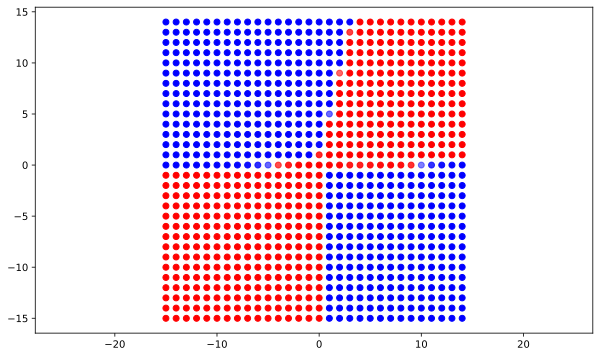

In [ ]:
clf = XORSolver(N)
num_iterations=10000
learning_rate =0.01
train_clf(clf, points, labels, num_iterations, learning_rate, seed=0)
visualize_clf(clf, points)

**EXERCISE 2**

In [91]:
import pandas as pd
df = pd.read_csv("harbour-space-text-mining-course/datasets/startup_investments/investments_VC.csv")
df.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (11,15,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,...,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H,Unnamed: 39
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,"17,50,000",acquired,USA,NY,New York City,...,0,0,0,0,0,0,0,0,0,NaN
1,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,"40,00,000",operating,USA,CA,Los Angeles,...,0,0,0,0,0,0,0,0,0,NaN
2,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,40000,operating,EST,NaN,Tallinn,...,0,0,0,0,0,0,0,0,0,NaN
3,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,"15,00,000",operating,GBR,NaN,London,...,0,0,0,0,0,0,0,0,0,NaN
4,/organization/r-ranch-and-mine,-R- Ranch and Mine,NaN,|Tourism|Entertainment|Games|,Tourism,60000,operating,USA,TX,Dallas,...,0,0,0,0,0,0,0,0,0,NaN


In [92]:
df['market']=df['market'].str.strip()
df['name']=df['name'].str.strip()

In [93]:
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from pprint import pprint
top_10_markets = df.groupby("market").size().sort_values(ascending=False).head(10).index
data_top_10 = df.loc[df['market'].isin(top_10_markets)].reset_index()
markets = data_top_10['market'].unique()
startup_names = data_top_10["name"].values
market_dic=defaultdict(list)
for market in top_10_markets:
  for i in range(data_top_10.shape[0]):
    if data_top_10['market'][i]==market:
      market_dic[market].append(data_top_10['name'][i])


In [94]:

# count the total number of letters
all_letters = set()
all_categories = set()
for market , names in market_dic.items():
  all_categories.add(market)
  for name in names:
    all_letters.update(list(name))
all_letters = list(sorted(all_letters))
all_categories = list(sorted(all_categories))

In [95]:
def name_to_tensor(name, all_letters):
    tensor = torch.zeros(len(name), 1, len(all_letters))
    for li, letter in enumerate(name):
        letter_idx = all_letters.index(letter)
        tensor[li][0][letter_idx] = 1  # one-hot encoding
    return tensor


In [96]:
categories_to_training=defaultdict(list)
le = LabelEncoder()
le.fit(all_categories)

for market,names in market_dic.items():
  encoded_market = le.transform([market])
  market_tensor = torch.tensor(encoded_market)


  for name in names:
    name_tensor=name_to_tensor(name,all_letters)
    sample=market_tensor,name_tensor
    categories_to_training[market].append(sample)

In [98]:
import torch
import torch.nn as nn


class ClassificationLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

        # keep hidden sise for initialization of h_0, c_0
        self.hidden_size = hidden_size

    def forward(self, x):
        # Set initial states
        h0 = torch.zeros(1, 1, self.hidden_size)
        c0 = torch.zeros(1, 1, self.hidden_size)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (seq_len, batch, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.out(out[-1, :, :])

        return self.softmax(out)

In [99]:
def process_sequence_classification_lstm(lstm, target_tensor, input_tensor, learning_rate):
    loss_function = nn.NLLLoss()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
  
    output = lstm(input_tensor)
    loss = loss_function(output, target_tensor)

    # backprop + update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

  0%|          | 0/100000 [00:00<?, ?it/s]

iteration 2000: LSTM loss 2.310136137187481
iteration 4000: LSTM loss 2.327095701098442
iteration 6000: LSTM loss 2.3568273252248764
iteration 8000: LSTM loss 2.3117186874747278
iteration 10000: LSTM loss 2.3068696585297586
iteration 12000: LSTM loss 2.316883495390415
iteration 14000: LSTM loss 2.3260959061384203
iteration 16000: LSTM loss 2.3506985431313514
iteration 18000: LSTM loss 2.3151720727682115
iteration 20000: LSTM loss 2.334289676576853
iteration 22000: LSTM loss 2.3380471895933153
iteration 24000: LSTM loss 2.301299914956093
iteration 26000: LSTM loss 2.3060642206668853
iteration 28000: LSTM loss 2.325970287322998
iteration 30000: LSTM loss 2.3338141882419587
iteration 32000: LSTM loss 2.3510025328993795
iteration 34000: LSTM loss 2.323480684906244
iteration 36000: LSTM loss 2.345728683650494
iteration 38000: LSTM loss 2.3335187377929687
iteration 40000: LSTM loss 2.3652468779981137
iteration 42000: LSTM loss 2.3392141647040843
iteration 44000: LSTM loss 2.3556635040044784


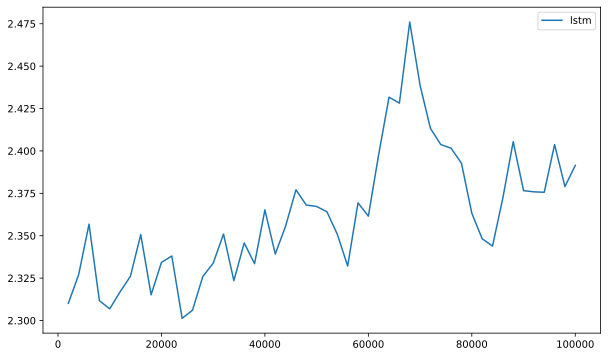

In [115]:
n_hidden = 128
classification_lstm = ClassificationLSTM(len(all_letters), n_hidden, len(all_categories))
import math
from tqdm.notebook import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
random.seed(0)

n_iters = 100000
print_every = 2000

all_losses = []
iterations = []
losses = []
all_rnn_losses = []
rnn_losses = []

for i in tqdm(range(1, n_iters + 1)):
    random_category = random.choice(all_categories)
    market_tensor, name_tensor = random.choice(categories_to_training[random_category])

    loss = process_sequence_classification_lstm(classification_lstm, market_tensor, name_tensor, 0.0001)
    all_losses.append(loss)
    if i % print_every == 0:
        iterations.append(i)
        avg_loss = np.mean(all_losses[-print_every:])
        losses.append(avg_loss)
        print(f"iteration {i}: LSTM loss {avg_loss}")

plt.plot(iterations, losses, label="lstm")
plt.legend()
plt.show()